In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
# import sumo as sm
import os
from traffic_initialization import *
import sys
from bs4 import BeautifulSoup
import tqdm
import pandas as pd

# New handy interface is here!
# Check interface.py for possible parameters
from interface import Simulation
%env SUMO_HOME=/usr/share/sumo
from datetime import datetime

import concurrent.futures

env: SUMO_HOME=/usr/share/sumo


# Введение

Наша задача предполагала оптимизацию расстояния между машинами на дороге с целью улучшения трафика. В этом сегменте укажем несколько вводных, а также допущений, принятых в нашем исследовании.

1. Действие происходит на относительно небольшом участке дороги.
2. Машины появляются на случайных полосах в начале участка, могут съехать на любом съезде.
3. Все машины одинаковы.
4. Все водители равноправны и всегда соблюдают рекомендации по соблюдению дистанции.
5. Все водители имеют полную информацию о дороге, по которой едут.

# Доказательство существования эффекта

Хотя бытовой опыт и подсказывает нам, что при соблюдении некоторой дистанции водителями на дороге, пробки зачастую рассасываются быстрее, но в наших приближениях это вообще-то неочевидно. Например, если увеличивать расстояние между машинами по всей дороге одновременно - результат окажется тривиален: чем меньше расстояние между машинами - тем больше скорость потока.

In [37]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()


def throughput(N, d0, d1, d2, d3, default_gap=3, N_ave=12):
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

In [45]:
X = np.linspace(0, 20, 10)
Y = np.zeros((X.shape))

for i in tqdm.tqdm(range(X.shape[0])):
    Y[i], _ = throughput(N=100, d0=X[i], d1=X[i], d2=X[i], d3=X[i], default_gap=X[i], N_ave=8)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


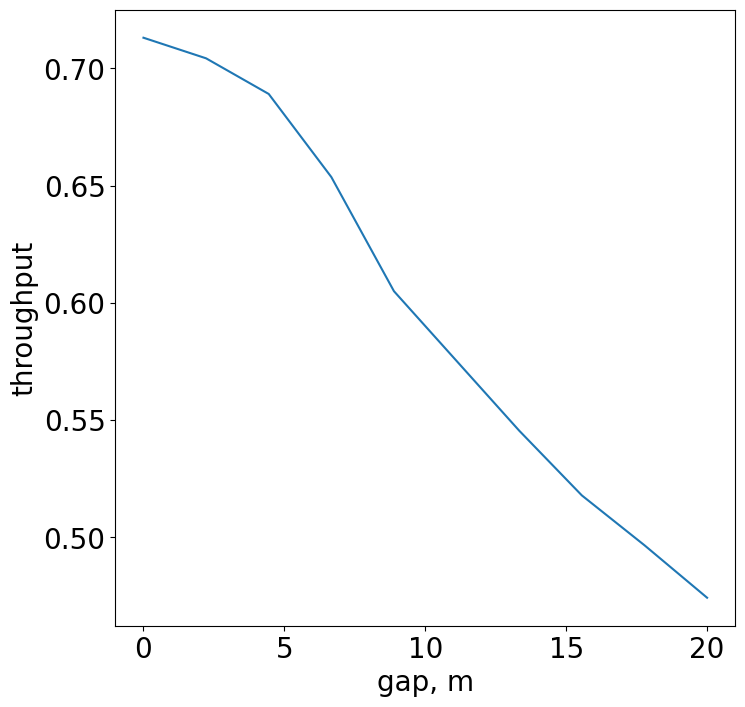

In [46]:
plt.subplots(figsize=(8, 8))
plt.plot(X, Y)
plt.xlabel('gap, m')
plt.ylabel('throughput')
plt.show()

Однако, если увеличить растояние на между машинами на линиях, заканчивающихся тупиком, можно получить выигрыш во времени.

In [29]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test1', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=4)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 596.0 sec


In [30]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test2', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=20)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 494.0 sec


In [54]:
X = np.linspace(0, 20, 20)
Y = np.linspace(0, 20, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=5000, d0=X[i], d1=X[i], d2=Y[i], d3=Y[i], default_gap=Y[i], N_ave=8)

 10%|████                                    | 2/20 [40:10<6:01:34, 1205.27s/it]

Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

In [52]:
X = np.linspace(0, 20, 20)
Y = np.linspace(0, 20, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
        seed_list = np.random.randint(-2**30, 2**30, Y.shape[0])
        with concurrent.futures.ThreadPoolExecutor(max_workers=Y.shape[0]) as executor:
            futures = [executor.submit(single_simulation, index, seed, 5000, X[i], X[i], Y[index], Y[index], Y[index]) 
                       for index, seed in enumerate(seed_list)]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]   
        Z[i, :] = .(results)
        

100%|██████████████████████████████████████████| 20/20 [35:34<00:00, 106.73s/it]


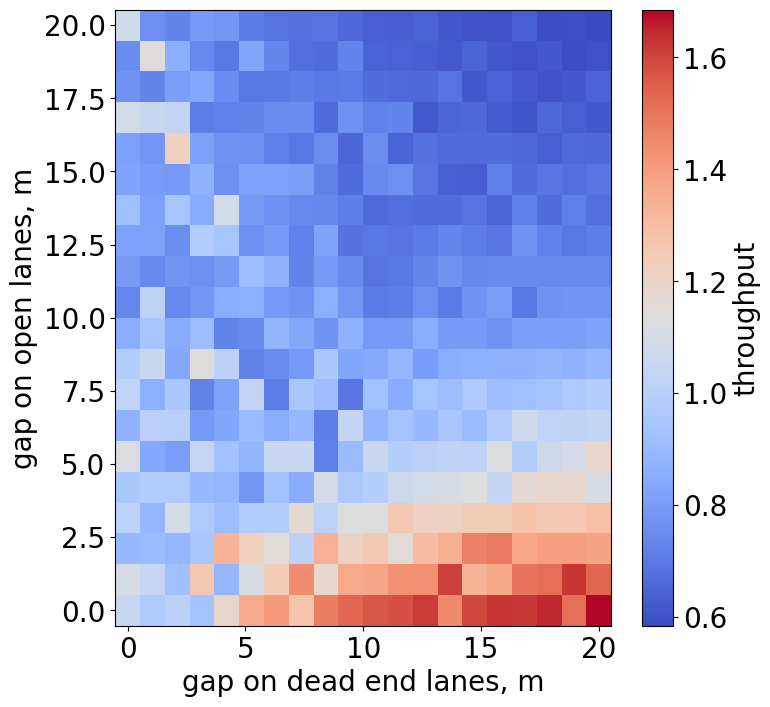

In [53]:
fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 8))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'gap on open lanes, m'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()

In [49]:
X = np.linspace(0, 20, 20)
Y = np.linspace(1000, 5000, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=Y[i], d0=X[i], d1=X[i], d2=3, d3=3, default_gap=3, N_ave=8)

 30%|████████████▉                              | 6/20 [16:26<38:21, 164.43s/it]

Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 8))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'cars in simulation'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()

# Optimization with annealing

In [5]:
# simple throughput function with two gaps parameters

def loss(d, N):

    d0 = d[0]
    d1 = d[1]
    
    ans = 0
    
    for n in range(10):

        sim = Simulation(start_road='E0', end_road='E2', N=N, work_dir='./xml_data/test6', net_data='test6.net.xml')
        sim.set_calibrator(road='E0', gap=3)
        sim.set_calibrator(road='E1', lane=['0', '1'], gap=d0)
        sim.set_calibrator(road='E1', lane=['2'], gap=d1)
        sim.set_calibrator(road='E1', lane=['3'], gap=2)
        sim.set_calibrator(road='E2', gap=1.5)
        sim.run()
        ans += sim.get_mean_throughput()

    return -ans/10

In [6]:
# simple optimization

N_arr = np.zeros(13)
opt_d = np.zeros((13, 2))
opt_throughput = np.zeros(13)

for n in tqdm.tqdm(range(12)):

    N = 4150 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    opt_throughput[n] = -sol.fun
    
    np.savez('res_data/annealing_res', opt_d=opt_d, N_arr=N_arr, opt_throughput=opt_throughput)


  0%|                                                    | 0/12 [05:59<?, ?it/s]

Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

In [10]:
data = np.load('res_data/annealing_res.npz')
data['N_arr']

array([   0., 4150., 4300., 4450., 4600., 4750., 4900.,    0.,    0.,
          0.,    0.,    0.,    0.])

time: 3.57 ms (started: 2024-04-25 18:21:23 +03:00)


# Optimization with ML

In [3]:
from Some_models import OptimalLoss_Q, OptimalDist

2024-04-24 19:57:14.788130: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 19:57:14.788378: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:57:14.790130: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:57:14.811696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 19:57:15.201402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

time: 979 ms (started: 2024-04-24 19:57:14 +03:00)


In [ ]:
# csv datase creation

In [6]:
# simple throughput function with two gaps parameters

def throughput(d0, d1, d2, N):

    sim = Simulation(start_road='E0', end_road='E2', N=N, work_dir='./xml_data/test6', net_data='test6.net.xml')
    sim.set_calibrator(road='E0', gap=3)
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=2)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run()

    return sim.get_mean_throughput()

time: 298 µs (started: 2024-04-24 19:57:37 +03:00)


In [ ]:
while(True):
    # test6
    filename='csv_data/test6.csv'
    csv_data = pd.read_csv(filename)
    
    N = np.random.randint(3000, 8000)
    for i in range(500):
        rand = np.random.rand(3)
        d0 = 10 + 40*rand[0]
        d1 = 10 + 30*rand[1]
        d2 = 3 + 30*rand[2]
        
        csv_data.loc[len(csv_data)] = (d0, d1, d2, N, throughput(d0, d1, d2, N))
        csv_data.to_csv(filename, index=False) 

In [11]:
model = OptimalDist(grid_params=[(4000, 8000, 41), (10, 40, 2), (2, 20, 2)])
model.fit_func(еthroughput)

  0%|          | 0/98 [00:33<?, ?it/s]


ValueError: cannot set a row with mismatched columns

time: 33.3 s (started: 2024-04-24 20:08:33 +03:00)


# Creating of csv

In [3]:
throughput(20, 4, 6000)

1.2891872320004407

time: 27.8 s (started: 2024-04-24 18:31:17 +03:00)


In [4]:
throughput(20, 4, 6000)

1.2932371519835026

time: 27.7 s (started: 2024-04-24 18:31:45 +03:00)


In [18]:
cost(30, 20, 10, 6000)

1.2176827071439196

In [19]:
cost(30, 20, 10, 6000)

1.2098426779299611

In [10]:
cost(30, 20, 10, 3)

0.028846153846153848

In [ ]:
while(True):
    # test6
    filename='csv_data/test6.csv'
    csv_data = pd.read_csv(filename)
    
    N = np.random.randint(3000, 8000)
    for i in range(500):
        rand = np.random.rand(3)
        d0 = 10 + 40*rand[0]
        d1 = 10 + 30*rand[1]
        d2 = 3 + 30*rand[2]
        
        csv_data.loc[len(csv_data)] = (d0, d1, d2, N, sim.get_mean_throughput())
        csv_data.to_csv(filename, index=False) 